Found 1161 valid pairs.
Starting training...
Epoch 1/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.7498 - iou: 0.0353 - loss: 0.6939 - precision: 0.3500 - recall: 0.0376 - val_accuracy: 0.5147 - val_iou: 0.0985 - val_loss: 0.6124 - val_precision: 0.5587 - val_recall: 0.1069 - learning_rate: 1.0000e-04
Epoch 2/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.7790 - iou: 0.0967 - loss: 0.6659 - precision: 0.8714 - recall: 0.0975 - val_accuracy: 0.5206 - val_iou: 0.2782 - val_loss: 0.6893 - val_precision: 0.5242 - val_recall: 0.3723 - learning_rate: 1.0000e-04
Epoch 3/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8009 - iou: 0.0938 - loss: 0.6535 - precision: 0.8446 - recall: 0.0952 - val_accuracy: 0.5080 - val_iou: 0.3719 - val_loss: 1.5764 - val_precision: 0.5039 - val_recall: 0.5868 - learning_rate: 1.0000e-04
Epoch 4/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.7896 - iou: 0.0863 - loss: 0.6489 - precision: 0.9313 - recall: 0.0

KeyError: 'binary_io_u'

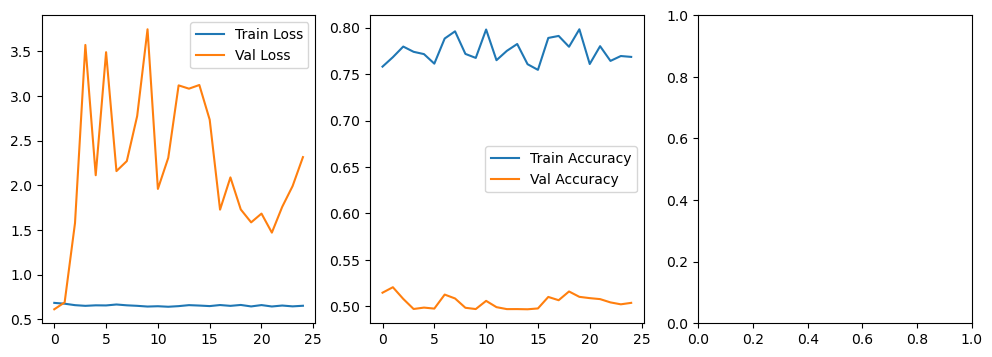

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Force CPU
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)
output_shape = (50, 50, 1)
batch_size = 4
learning_rate = 1e-4
epochs = 200
block_size = 10

# Improved Loss Function with shape checking
def improved_loss(y_true, y_pred):
    # Ensure shapes match by cropping if necessary
    if y_pred.shape[1] != y_true.shape[1] or y_pred.shape[2] != y_true.shape[2]:
        y_pred = tf.image.resize_with_crop_or_pad(y_pred, y_true.shape[1], y_true.shape[2])
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Binary Cross Entropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Dice Loss
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    dice_loss = 1 - dice
    
    return 0.5 * bce + 0.5 * dice_loss

# Corrected Model Architecture with exact output shape
def build_enhanced_model(input_shape, output_shape):
    # Dual inputs with separate feature extraction
    input_even = layers.Input(shape=input_shape, name="even_input")
    input_odd = layers.Input(shape=input_shape, name="odd_input")
    
    # Parallel feature extraction
    def feature_extractor(x):
        x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x
    
    even_features = feature_extractor(input_even)
    odd_features = feature_extractor(input_odd)
    
    # Feature fusion
    x = layers.Concatenate()([even_features, odd_features])
    x = layers.Resizing(output_shape[0]//2, output_shape[1]//2)(x)
    
    # U-Net style decoder
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    
    # Final output with precise shape
    output = layers.Conv2D(1, 1, activation='sigmoid')(x)
    output = layers.Resizing(output_shape[0], output_shape[1])(output)
    
    return models.Model(inputs=[input_even, input_odd], outputs=output)

# Data Generator (unchanged)
class ImprovedDataGenerator(Sequence):
    def __init__(self, even_dir, odd_dir, out_dir, batch_size, input_shape, output_shape, pairs, augment=False):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.out_dir = out_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.pairs = pairs
        self.augment = augment
        
        # Enhanced augmentation pipeline
        self.augmentation = KerasImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=[0.8, 1.2],  # Both zoom-in and zoom-out
            shear_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect',  # Better edge handling
            brightness_range=[0.8, 1.2],
            channel_shift_range=20.0
        ) if augment else None
        
        # Precompute class weights if needed
        self.class_weights = self._calculate_class_weights()

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def _calculate_class_weights(self):
        """Calculate class weights for imbalanced data"""
        # Sample some batches to estimate class distribution
        sample_size = min(100, len(self.pairs))
        y_samples = []
        for i in range(0, sample_size, self.batch_size):
            _, y_batch = self._load_batch(i)
            y_samples.append(y_batch)
        
        y_all = np.concatenate(y_samples)
        unique, counts = np.unique(y_all, return_counts=True)
        class_weights = len(y_all) / (len(unique) * counts)
        return dict(zip(unique, class_weights))

    def _load_batch(self, idx):
        batch = self.pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        even_batch = np.zeros((len(batch), *self.input_shape), dtype=np.float32)
        odd_batch = np.zeros((len(batch), *self.input_shape), dtype=np.float32)
        out_batch = np.zeros((len(batch), *self.output_shape), dtype=np.float32)

        for i, (e_path, o_path, m_path) in enumerate(batch):
            try:
                # Load images with error handling
                even = np.array(Image.open(e_path).convert('L').resize(self.input_shape[:2]))
                odd = np.array(Image.open(o_path).convert('L').resize(self.input_shape[:2]))
                matrix_img = np.array(Image.open(m_path).convert('L').resize(self.output_shape[:2]))

                # Normalize and reshape
                even = np.expand_dims(even, axis=-1).astype(np.float32) / 255.0
                odd = np.expand_dims(odd, axis=-1).astype(np.float32) / 255.0
                matrix_img = (matrix_img > 30).astype(np.float32)  # Adaptive thresholding
                matrix_img = np.expand_dims(matrix_img, axis=-1)

                # Store in batches
                even_batch[i] = even
                odd_batch[i] = odd
                out_batch[i] = matrix_img

            except Exception as e:
                print(f"Error loading {e_path}: {str(e)}")
                # Fill with zeros if error occurs
                even_batch[i] = np.zeros(self.input_shape, dtype=np.float32)
                odd_batch[i] = np.zeros(self.input_shape, dtype=np.float32)
                out_batch[i] = np.zeros(self.output_shape, dtype=np.float32)

        return (even_batch, odd_batch), out_batch

    def _augment_batch(self, even, odd, mask):
        """Apply coordinated augmentation to image pairs"""
        seed = np.random.randint(1e6)
        
        # Apply spatial transformations
        even_aug = self.augmentation.random_transform(even, seed=seed)
        odd_aug = self.augmentation.random_transform(odd, seed=seed)
        
        # Apply the same transformation to mask
        mask_aug = self.augmentation.random_transform(mask, seed=seed)
        mask_aug = (mask_aug > 0.5).astype(np.float32)  # Re-binarize
        
        # Additional augmentations
        if np.random.rand() > 0.5:
            # Random gamma correction
            gamma = np.random.uniform(0.8, 1.2)
            even_aug = np.power(even_aug, gamma)
            odd_aug = np.power(odd_aug, gamma)
        
        if np.random.rand() > 0.5:
            # Add Gaussian noise
            noise_level = np.random.uniform(0, 0.05)
            even_aug = even_aug + np.random.normal(0, noise_level, even_aug.shape)
            odd_aug = odd_aug + np.random.normal(0, noise_level, odd_aug.shape)
        
        # Clip values
        even_aug = np.clip(even_aug, 0, 1)
        odd_aug = np.clip(odd_aug, 0, 1)
        
        return even_aug, odd_aug, mask_aug

    def __getitem__(self, idx):
        (even_batch, odd_batch), out_batch = self._load_batch(idx)
        
        if self.augment:
            for i in range(len(even_batch)):
                even_batch[i], odd_batch[i], out_batch[i] = self._augment_batch(
                    even_batch[i], 
                    odd_batch[i], 
                    out_batch[i]
                )
        
        # Add channel dimension if needed
        if len(even_batch.shape) == 3:
            even_batch = np.expand_dims(even_batch, axis=-1)
            odd_batch = np.expand_dims(odd_batch, axis=-1)
        
        return (even_batch, odd_batch), out_batch

    def on_epoch_end(self):
        """Shuffle pairs after each epoch"""
        np.random.shuffle(self.pairs)
        
    def get_class_weights(self):
        """Get computed class weights for imbalanced data"""
        return self.class_weights

# Training Setup
def get_valid_pairs():
    pairs = []
    for f in os.listdir(output_dir):
        if not f.endswith('.png'):
            continue
        base = f[:-4]
        even_path = os.path.join(input_even_dir, f"{base}_even.png")
        odd_path = os.path.join(input_odd_dir, f"{base}_odd.png")
        out_path = os.path.join(output_dir, f)
        if os.path.exists(even_path) and os.path.exists(odd_path):
            pairs.append((even_path, odd_path, out_path))
    return pairs

if __name__ == "__main__":
    # Data preparation
    pairs = get_valid_pairs()
    print(f"Found {len(pairs)} valid pairs.")
    np.random.shuffle(pairs)
    split = int(0.8 * len(pairs))
    train_pairs = pairs[:split]
    val_pairs = pairs[split:]

    # Generators
    train_gen = ImprovedDataGenerator(input_even_dir, input_odd_dir, output_dir, 
                                    batch_size, input_shape, output_shape, 
                                    train_pairs, augment=True)
    val_gen = ImprovedDataGenerator(input_even_dir, input_odd_dir, output_dir, 
                                  batch_size, input_shape, output_shape, 
                                  val_pairs)

    # Model
    model = build_enhanced_model(input_shape, output_shape)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss=improved_loss,
        metrics=[
            'accuracy',
            tf.keras.metrics.BinaryIoU(target_class_ids=[1], name='iou'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',  # Using new .keras format
            monitor='val_iou',
            mode='max',
            save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_iou',
            patience=15,
            mode='max',
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        ),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ]

    # Training
    print("Starting training...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluation
    print("Evaluating model...")
    results = model.evaluate(val_gen)
    print(f"Validation Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}, IoU: {results[2]:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou'], label='Train IoU')
    plt.plot(history.history['val_iou'], label='Val IoU')
    plt.legend()
    plt.tight_layout()
    plt.show()

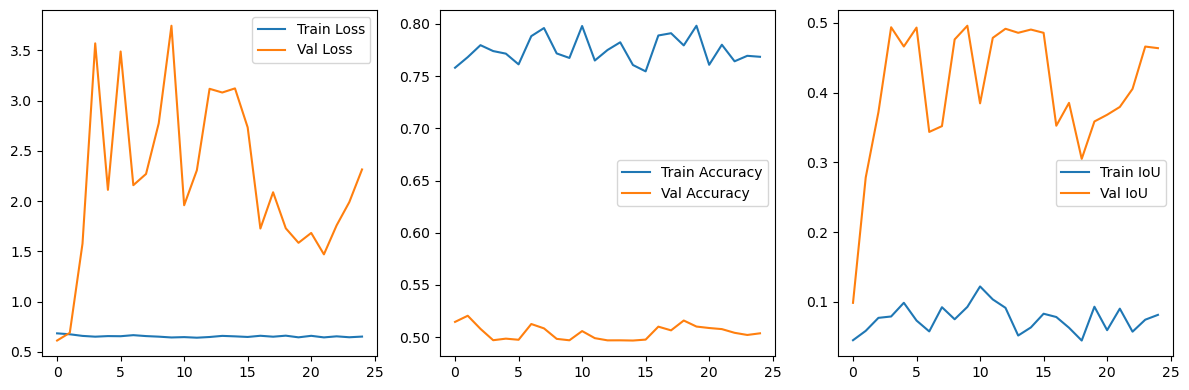

In [3]:
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou'], label='Train IoU')
    plt.plot(history.history['val_iou'], label='Val IoU')
    plt.legend()
    plt.tight_layout()
    plt.show()

Found 1161 valid image pairs.
Computing correlation on 200 samples...

Correlation Matrix:
                  Even Image Mean  Odd Image Mean  Output Mask Mean
Even Image Mean          1.000000       -0.085086         -0.640808
Odd Image Mean          -0.085086        1.000000          0.049017
Output Mask Mean        -0.640808        0.049017          1.000000


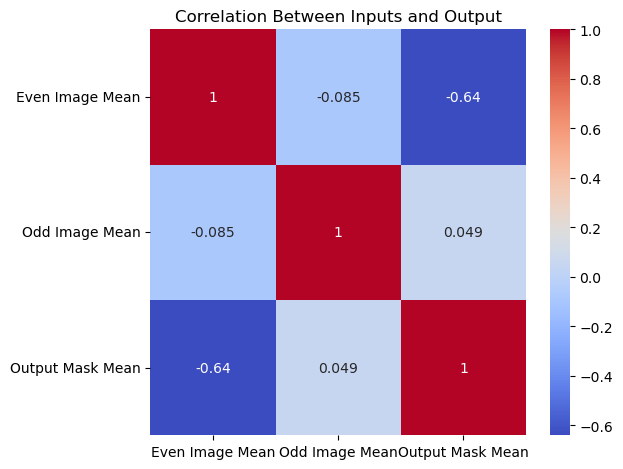

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# === Configuration ===
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32)
output_shape = (50, 50)

# === Get Valid File Triplets ===
def get_valid_pairs():
    pairs = []
    for f in os.listdir(output_dir):
        if not f.endswith('.png'):
            continue
        base = f[:-4]
        even_path = os.path.join(input_even_dir, f"{base}_even.png")
        odd_path = os.path.join(input_odd_dir, f"{base}_odd.png")
        out_path = os.path.join(output_dir, f)
        if os.path.exists(even_path) and os.path.exists(odd_path):
            pairs.append((even_path, odd_path, out_path))
    return pairs

# === Compute Correlation ===
def compute_dataset_correlation(pairs, num_samples=200):
    even_means = []
    odd_means = []
    output_means = []

    print(f"Computing correlation on {min(len(pairs), num_samples)} samples...")

    for i, (even_path, odd_path, out_path) in enumerate(pairs[:num_samples]):
        try:
            even = np.array(Image.open(even_path).convert('L').resize(input_shape)) / 255.0
            odd = np.array(Image.open(odd_path).convert('L').resize(input_shape)) / 255.0
            out = np.array(Image.open(out_path).convert('L').resize(output_shape)) > 30
            out = out.astype(np.float32)

            even_means.append(np.mean(even))
            odd_means.append(np.mean(odd))
            output_means.append(np.mean(out))

        except Exception as e:
            print(f"Skipping {even_path}: {e}")
            continue

    # DataFrame of means
    df = pd.DataFrame({
        'Even Image Mean': even_means,
        'Odd Image Mean': odd_means,
        'Output Mask Mean': output_means
    })

    # Compute and plot correlation
    corr_matrix = df.corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title("Correlation Between Inputs and Output")
    plt.tight_layout()
    plt.show()

# === Main Execution ===
if __name__ == "__main__":
    pairs = get_valid_pairs()
    print(f"Found {len(pairs)} valid image pairs.")
    
    if len(pairs) == 0:
        print("No valid data found! Check your file paths.")
    else:
        compute_dataset_correlation(pairs)



Trial 30 Complete [00h 03m 27s]
val_binary_io_u: 0.24600858986377716

Best val_binary_io_u So Far: 0.24600601196289062
Total elapsed time: 00h 35m 35s
✅ Best Filters: 32, Best LR: 0.0009309776039858184
🔁 Training...
Epoch 1/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.4936 - binary_io_u: 0.2471 - loss: 0.5822 - val_accuracy: 0.4920 - val_binary_io_u: 0.2460 - val_loss: 0.5867 - learning_rate: 9.3098e-04
Epoch 2/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4992 - binary_io_u: 0.2508 - loss: 0.5797 - val_accuracy: 0.4920 - val_binary_io_u: 0.2461 - val_loss: 0.5892 - learning_rate: 9.3098e-04
Epoch 3/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4984 - binary_io_u: 0.2495 - loss: 0.5792 - val_accuracy: 0.4920 - val_binary_io_u: 0.2460 - val_loss: 0.5863 - learning_rate: 9.3098e-04
Epoch 4/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4967 - binary_io_u: 0.2484 - loss: 0.5794 - val_accuracy: 0.4920 - val_binary_io_u: 0.2466 - val_l

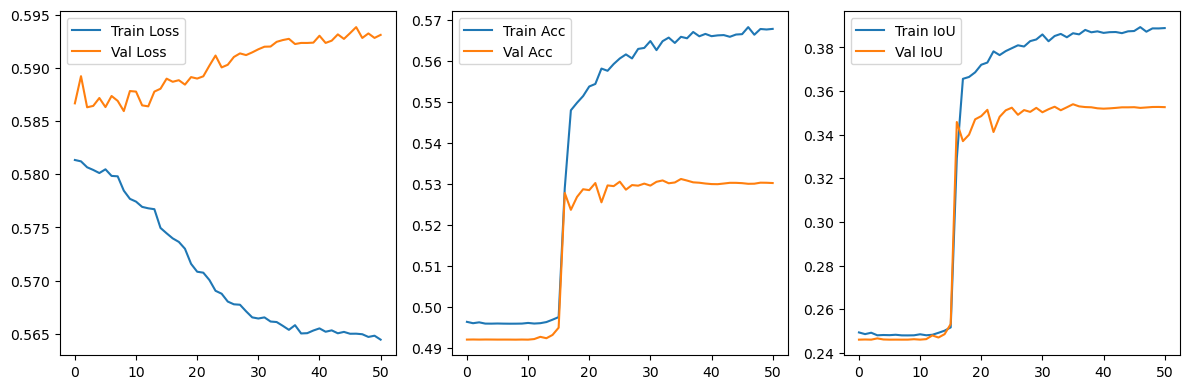

In [5]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
import warnings
import keras_tuner as kt

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# === Configuration ===
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)
output_shape = (50, 50, 1)
batch_size = 4
learning_rate = 1e-4
epochs = 200

# === Loss Function ===
def improved_loss(y_true, y_pred):
    if y_pred.shape[1] != y_true.shape[1] or y_pred.shape[2] != y_true.shape[2]:
        y_pred = tf.image.resize_with_crop_or_pad(y_pred, y_true.shape[1], y_true.shape[2])
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    return 0.5 * bce + 0.5 * (1 - dice)

# === Model Builder for Keras Tuner ===
def build_model(hp):
    input_even = layers.Input(shape=input_shape)
    input_odd = layers.Input(shape=input_shape)

    def extractor(x, filters):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(filters * 2, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x

    filters = hp.Int('filters', 16, 64, step=16)
    lr = hp.Float('lr', 1e-5, 1e-3, sampling='log')

    even_feat = extractor(input_even, filters)
    odd_feat = extractor(input_odd, filters)

    x = layers.Concatenate()([even_feat, odd_feat])
    x = layers.Resizing(output_shape[0]//2, output_shape[1]//2)(x)
    x = layers.Conv2D(filters * 4, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(filters * 2, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    output = layers.Conv2D(1, 1, activation='sigmoid')(x)
    output = layers.Resizing(output_shape[0], output_shape[1])(output)

    model = models.Model(inputs=[input_even, input_odd], outputs=output)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss=improved_loss,
        metrics=['accuracy', tf.keras.metrics.BinaryIoU()]
    )
    return model

# === Data Generator ===
class ImprovedDataGenerator(Sequence):
    def __init__(self, even_dir, odd_dir, out_dir, batch_size, input_shape, output_shape, pairs, augment=False):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.out_dir = out_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.pairs = pairs
        self.augment = augment
        self.augmentation = KerasImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect'
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        even_batch = np.zeros((len(batch), *self.input_shape), dtype=np.float32)
        odd_batch = np.zeros((len(batch), *self.input_shape), dtype=np.float32)
        out_batch = np.zeros((len(batch), *self.output_shape), dtype=np.float32)

        for i, (e_path, o_path, m_path) in enumerate(batch):
            try:
                even = np.array(Image.open(e_path).convert('L').resize(self.input_shape[:2])) / 255.0
                odd = np.array(Image.open(o_path).convert('L').resize(self.input_shape[:2])) / 255.0
                matrix = (np.array(Image.open(m_path).convert('L').resize(self.output_shape[:2])) > 30).astype(np.float32)

                even_batch[i] = np.expand_dims(even, -1)
                odd_batch[i] = np.expand_dims(odd, -1)
                out_batch[i] = np.expand_dims(matrix, -1)
            except Exception as ex:
                print(f"Error loading {e_path}: {ex}")

        return (even_batch, odd_batch), out_batch

    def on_epoch_end(self):
        np.random.shuffle(self.pairs)

# === Get Pairs ===
def get_valid_pairs():
    pairs = []
    for f in os.listdir(output_dir):
        if not f.endswith('.png'):
            continue
        base = f[:-4]
        even_path = os.path.join(input_even_dir, f"{base}_even.png")
        odd_path = os.path.join(input_odd_dir, f"{base}_odd.png")
        out_path = os.path.join(output_dir, f)
        if os.path.exists(even_path) and os.path.exists(odd_path):
            pairs.append((even_path, odd_path, out_path))
    return pairs

# === Correlation Function ===
def compute_dataset_correlation(pairs, num_samples=200):
    even_means, odd_means, output_means = [], [], []

    for i, (e_path, o_path, m_path) in enumerate(pairs[:num_samples]):
        try:
            even = np.array(Image.open(e_path).convert('L').resize(input_shape[:2])) / 255.0
            odd = np.array(Image.open(o_path).convert('L').resize(input_shape[:2])) / 255.0
            output = (np.array(Image.open(m_path).convert('L').resize(output_shape[:2])) > 30).astype(np.float32)
            even_means.append(np.mean(even))
            odd_means.append(np.mean(odd))
            output_means.append(np.mean(output))
        except:
            continue

    df = pd.DataFrame({
        'Even Image Mean': even_means,
        'Odd Image Mean': odd_means,
        'Output Mask Mean': output_means
    })

    print("Correlation Matrix:\n", df.corr())
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title("Input-Output Correlation")
    plt.tight_layout()
    plt.show()

# === Hyperparameter Tuning ===
def tune_hyperparameters(train_gen, val_gen):
    tuner = kt.Hyperband(
        build_model,
        objective='val_binary_io_u',
        max_epochs=20,
        factor=3,
        directory='tuner_dir',
        project_name='gray_tuning'
    )

    tuner.search(train_gen, validation_data=val_gen, epochs=20,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print(f"✅ Best Filters: {best_hps['filters']}, Best LR: {best_hps['lr']}")
    return tuner.get_best_models(1)[0]

# === MAIN ===
if __name__ == "__main__":
    pairs = get_valid_pairs()
    print(f"Found {len(pairs)} valid samples.")
    
    compute_dataset_correlation(pairs)  # Analyze data

    np.random.shuffle(pairs)
    split = int(0.8 * len(pairs))
    train_pairs, val_pairs = pairs[:split], pairs[split:]

    train_gen = ImprovedDataGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, train_pairs, augment=True)
    val_gen = ImprovedDataGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, val_pairs)

    # Tune hyperparameters
    model = tune_hyperparameters(train_gen, val_gen)

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_binary_io_u', mode='max'),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_io_u', patience=15, mode='max', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ]

    # Training
    print("🔁 Training...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks)

    # Evaluation
    print("🔍 Evaluating model...")
    results = model.evaluate(val_gen)
    print(f"Validation Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}, IoU: {results[2]:.4f}")

    # Plot history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(history.history['binary_io_u'], label='Train IoU')
    plt.plot(history.history['val_binary_io_u'], label='Val IoU')
    plt.legend()
    plt.tight_layout()
    plt.show()
